# Are we undercounting Global Methane Emissions?

According to the United Nations Environment Program "methane is the primary contributor to the formation of ground-level ozone." Over 20 years, "it is 80 times more potent at warming than carbon dioxide." [(UNEP)](https://www.unep.org/news-and-stories/story/methane-emissions-are-driving-climate-change-heres-how-reduce-them).  In fact, one kilogram of CH4 produced is equivalent to 25 kilograms of CO2 [(Econometra)](https://ecometrica.com/assets/GHGs-CO2-CO2e-and-Carbon-What-Do-These-Mean-v2.1.pdf).  

The agricultural industry is the primary producer of methane emissions globally.  While the cattle industry is a well known culprit, paddy rice cultivation accounts for another 8 per cent of human linked emissions[(UNEP)](https://www.unep.org/news-and-stories/story/.methane-emissions-are-driving-climate-change-heres-how-reduce-them).


## How Rice Paddy CH4 Emissions are Measured.

Methane estimates are calcuated by multipling the hecatares of rice paddy in cultivation by a conversion factor.   

The Food and Agricultural Organization of the United Nations [(FAOSTAT)](https://www.fao.org/faostat/en/#home) is the most trusted provider of methane emission estimates.  The accuracy of their data however, can be questioned as the organization relies upon official government sources which may be manipulated.

Climate TRACE [(Climate TRACE)](https://www.climatetrace.org)on the other hand estimates emission levels by calculating the area of cultivated paddies with satalite imaging.   While this method may undercount small fields and cultivation at higher altitudes, the metric does not rely upon possibly manipulated sources. In theory, this should result in more accurate predictions.  


```{note}
It is important to note that FAOSTAT and TRACE estimate emissions with different conversion factors. 
```


## Difference between FAOSTAT and TRACE Estimates.

### Python Libraries Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import contextily as cx
from shapely.geometry import Point, LineString, Polygon
import numpy as np
from scipy.spatial import cKDTree
from geopy.distance import distance
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable


/Users/jnapolitano/venvs/finance/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Data Import

We will be reviewing the data provided by FAOSTAT and TRACE.  The dataframe imported was prepared for this post.  You may review the documentation [here](data_exploration_title)

In [2]:
filepath = "/Users/jnapolitano/Projects/wattime-takehome/data/MERGE_DATA_GEO.geojson"

merge_geo_df = gpd.read_file(filepath)

## Convert to 3857 for easier plotting and spatial math if necessary
merge_geo_df = merge_geo_df.to_crs(epsg=3857)


### CH4 Data

There is too much noise in the data to make sense of it as is.  Let's slice the totals to getter a better look.

In [3]:
ch4_data = merge_geo_df[['country_name_FAOSTAT', 'continent','CH4_abs_percent_diff_totals', 'CH4_relative_percent_diff_totals', 'CH4_diff_totals','2015', 'tCH4_2015','2016', 'tCH4_2016','2017', 'tCH4_2017','2017', 'tCH4_2017','2018', 'tCH4_2018', '2019', 'tCH4_2019']].copy()
ch4_data

,country_name_FAOSTAT,continent,CH4_abs_percent_diff_totals,CH4_relative_percent_diff_totals,CH4_diff_totals,2015,tCH4_2015,2016,tCH4_2016,2017,tCH4_2017,2017,tCH4_2017,2018,tCH4_2018,2019,tCH4_2019
0,Bangladesh,Asia,63.425917,-92.881337,-5.265110e+06,1131293.4,2.344420e+06,1.093480e+06,2.278158e+06,1.154531e+06,2.098958e+06,1.154531e+06,2.098958e+06,1.144591e+06,2.141231e+06,1.144745e+06,2.070985e+06
1,Brazil,South America,93.222402,-174.610414,-1.096923e+06,138910.3,3.410233e+05,1.262782e+05,3.104189e+05,1.303229e+05,3.725173e+05,1.303229e+05,3.725173e+05,1.216152e+05,3.717030e+05,1.110848e+05,3.294713e+05
2,China,Asia,9.421813,-9.887609,-2.642293e+06,5406593.9,6.133647e+06,5.399920e+06,5.859531e+06,5.400129e+06,6.355071e+06,5.400129e+06,6.355071e+06,5.302173e+06,5.413962e+06,5.214455e+06,5.603352e+06
3,Spain,Europe,124.705066,76.811284,2.069382e+05,55082.2,1.141464e+04,5.507310e+04,1.334803e+04,5.423240e+04,1.217299e+04,5.423240e+04,1.217299e+04,5.292500e+04,1.405410e+04,5.209850e+04,1.148324e+04
4,Indonesia,Asia,70.153790,51.936188,6.172158e+06,2407953.5,1.283649e+06,2.387656e+06,1.023129e+06,2.425291e+06,9.615327e+05,2.425291e+06,9.615327e+05,2.405614e+06,1.176982e+06,2.257604e+06,1.266668e+06
5,India,Asia,32.086209,-38.217479,-8.806357e+06,4580248.4,6.219887e+06,4.559136e+06,5.309413e+06,4.620791e+06,6.228451e+06,4.620791e+06,6.228451e+06,4.661155e+06,6.589798e+06,4.621417e+06,7.501556e+06
6,Iran (Islamic Republic of),Asia,13.260902,12.436318,6.526191e+04,116486.7,8.774407e+04,1.310085e+05,9.180121e+04,8.723360e+04,9.620217e+04,8.723360e+04,9.620217e+04,9.393660e+04,8.875744e+04,9.610340e+04,9.500199e+04
7,Italy,Europe,80.187551,57.238482,3.267972e+05,114574.8,4.995968e+04,1.180030e+05,4.937785e+04,1.180030e+05,5.443679e+04,1.180030e+05,5.443679e+04,1.094638e+05,4.469902e+04,1.108951e+05,4.566914e+04
8,Japan,Asia,36.874729,31.134372,5.053990e+05,330353.1,2.305465e+05,3.264030e+05,2.284133e+05,3.237003e+05,2.708935e+05,3.237003e+05,2.708935e+05,3.222450e+05,1.548252e+05,3.205818e+05,2.332056e+05
9,Cambodia,Asia,14.304565,-15.406481,-3.570168e+05,436826.0,4.954698e+05,4.590031e+05,5.731698e+05,4.737453e+05,4.517045e+05,4.737453e+05,4.517045e+05,4.793627e+05,5.592610e+05,4.683789e+05,5.947277e+05


#### CH4 Data Insights

* FAOSTAT underestimated by about 2.8 percent in comparison to TRACE.  
* FAOSTAT undestimated a total of 3,100,772 tonnes of methane over a 5 year period.  
 

### CH4 Plots

#### CH4 Relative Percent Differences Bar Plot

<AxesSubplot:title={'center':'Relative Percent Global CH4 Emissions 2015 - 2019'}, ylabel='Country Name'>

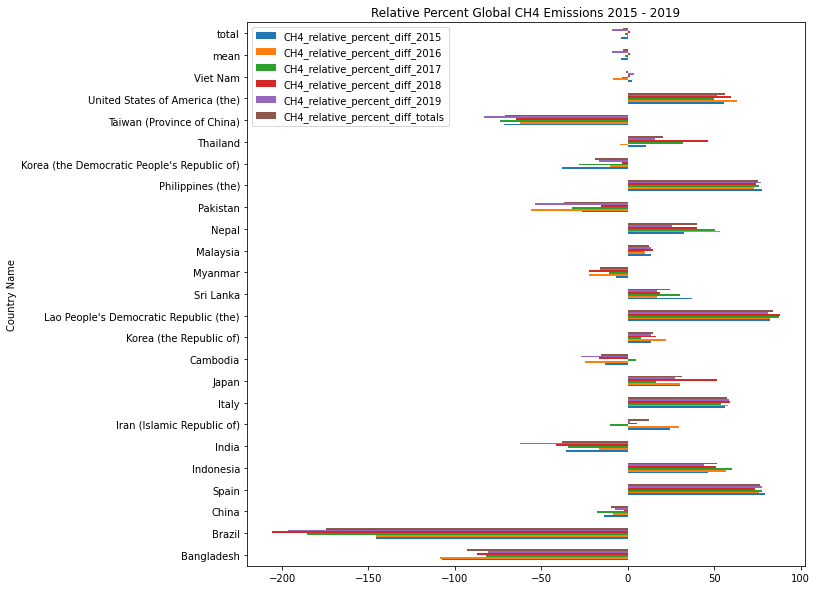

In [4]:
merge_geo_df.plot(kind = "barh", x = 'country_name_FAOSTAT', y = ['CH4_relative_percent_diff_2015', 'CH4_relative_percent_diff_2016','CH4_relative_percent_diff_2017', 'CH4_relative_percent_diff_2018', 'CH4_relative_percent_diff_2019','CH4_relative_percent_diff_totals'], xlabel = "Country Name", ylabel = "Tonnes CH4", title = "Relative Percent Global CH4 Emissions 2015 - 2019", figsize = (10,10))

#### CH4 Percent Differences Map

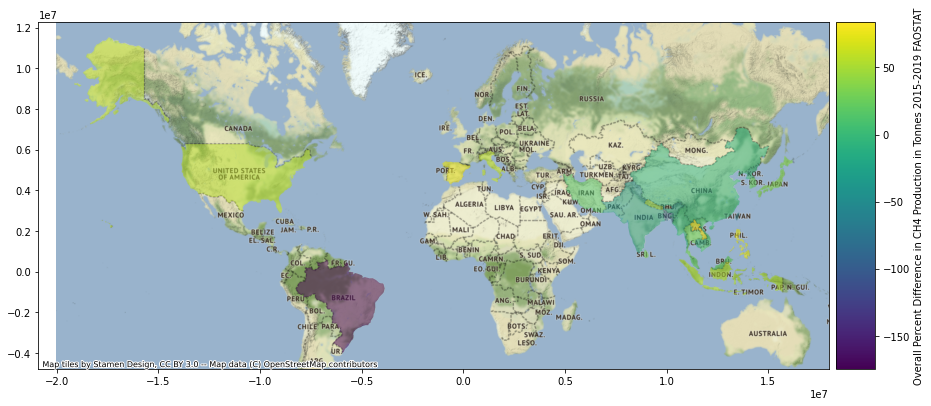

In [5]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merge_map = merge_geo_df.plot(column='CH4_relative_percent_diff_totals', ax=ax, legend=True, cax=cax, alpha = .5,legend_kwds={'label': "Overall Percent Difference in CH4 Production in Tonnes 2015-2019 FAOSTAT",
                        'orientation': "vertical"})
cx.add_basemap(merge_map, zoom=3)

### Discusion of Aggregated Methane Data Points

FAOSTAT on average undercounts by about 2.8 percent in comparison to the TRACE DATA.  It is also interesting to note that states with relatively inefficient beauracracies appear to under report their rice cultivation. 

## The Case for Climate Trace Estimates.

The TRACE and the FAOSTAT methods can both erroneously estimate methane emission.  Climate Trace's advantage is that hecatares of cultivation are estimated from satelleite imaging as opposed to government reports.  The result of which is a falsifiable report supported by empirical evidence.  Such Rrigourous data collection methodology builds a case that is difficult to refute to climate change naysayers.  Therefore, when measuring the CO2 equivalency of CH4 emissions I choose to use the Climate TRACE estimates.

## Measuring of CO2 Equivalency

CH4 can be converted to CO2 equivalency by multiplying the 1 kilogram of CH4 by 25.  The data frame below has been precalculated.

In [14]:
co2_data = merge_geo_df[['country_name_TRACE', 'continent','CO2_abs_percent_diff_totals', 'CO2_relative_percent_diff_totals', 'CO2_diff_totals','tCO2_2015_FAOSTAT','tCO2_2015_TRACE', 'tCO2_2016_FAOSTAT', 'tCO2_2016_TRACE', 'tCO2_2017_FAOSTAT', 'tCO2_2017_TRACE','tCO2_2018_FAOSTAT','tCO2_2018_TRACE', 'tCO2_2019_FAOSTAT','tCO2_2019_TRACE']].copy()
co2_data

,country_name_TRACE,continent,CO2_abs_percent_diff_totals,CO2_relative_percent_diff_totals,CO2_diff_totals,tCO2_2015_FAOSTAT,tCO2_2015_TRACE,tCO2_2016_FAOSTAT,tCO2_2016_TRACE,tCO2_2017_FAOSTAT,tCO2_2017_TRACE,tCO2_2018_FAOSTAT,tCO2_2018_TRACE,tCO2_2019_FAOSTAT,tCO2_2019_TRACE
0,Bangladesh,Asia,63.425917,-92.881337,-1.316277e+08,28282335.0,5.861049e+07,2.733701e+07,5.695395e+07,2.886328e+07,5.247394e+07,2.861478e+07,5.353076e+07,2.861864e+07,5.177463e+07
1,Brazil,South America,93.222402,-174.610414,-2.742306e+07,3472757.5,8.525583e+06,3.156955e+06,7.760473e+06,3.258072e+06,9.312934e+06,3.040380e+06,9.292575e+06,2.777120e+06,8.236783e+06
2,China,Asia,9.421813,-9.887609,-6.605732e+07,135164847.5,1.533412e+08,1.349980e+08,1.464883e+08,1.350032e+08,1.588768e+08,1.325543e+08,1.353491e+08,1.303614e+08,1.400838e+08
3,Spain,Europe,124.705066,76.811284,5.173455e+06,1377055.0,2.853661e+05,1.376828e+06,3.337007e+05,1.355810e+06,3.043248e+05,1.323125e+06,3.513524e+05,1.302462e+06,2.870810e+05
4,Indonesia,Asia,70.153790,51.936188,1.543040e+08,60198837.5,3.209122e+07,5.969141e+07,2.557824e+07,6.063226e+07,2.403832e+07,6.014035e+07,2.942454e+07,5.644011e+07,3.166670e+07
5,India,Asia,32.086209,-38.217479,-2.201589e+08,114506210.0,1.554972e+08,1.139784e+08,1.327353e+08,1.155198e+08,1.557113e+08,1.165289e+08,1.647450e+08,1.155354e+08,1.875389e+08
6,Iran (Islamic Republic of),Asia,13.260902,12.436318,1.631548e+06,2912167.5,2.193602e+06,3.275212e+06,2.295030e+06,2.180840e+06,2.405054e+06,2.348415e+06,2.218936e+06,2.402585e+06,2.375050e+06
7,Italy,Europe,80.187551,57.238482,8.169930e+06,2864370.0,1.248992e+06,2.950075e+06,1.234446e+06,2.950075e+06,1.360920e+06,2.736595e+06,1.117475e+06,2.772378e+06,1.141729e+06
8,Japan,Asia,36.874729,31.134372,1.263498e+07,8258827.5,5.763662e+06,8.160075e+06,5.710333e+06,8.092508e+06,6.772337e+06,8.056125e+06,3.870631e+06,8.014545e+06,5.830141e+06
9,Cambodia,Asia,14.304565,-15.406481,-8.925421e+06,10920650.0,1.238675e+07,1.147508e+07,1.432925e+07,1.184363e+07,1.129261e+07,1.198407e+07,1.398153e+07,1.170947e+07,1.486819e+07


```{note}
All differences are recorded as FAOSTAT - TRACE.
```

### CO2 Data Insights

* Total difference in 7,7519,300 tonnes of CO2equivalency between the FAOSTAT and TRACE data.
* Relative percent difference of -2.8 percent. 

### Tonnes C02 2015 - 2019 TRACE

In [15]:
TRACE_CO2_df = co2_data[['country_name_TRACE','tCO2_2015_TRACE','tCO2_2016_TRACE','tCO2_2017_TRACE','tCO2_2018_TRACE','tCO2_2019_TRACE',]].copy()
TRACE_CO2_df['Means'] = TRACE_CO2_df.select_dtypes(np.number).mean(axis=1)
TRACE_CO2_df

,country_name_TRACE,tCO2_2015_TRACE,tCO2_2016_TRACE,tCO2_2017_TRACE,tCO2_2018_TRACE,tCO2_2019_TRACE,Means
0,Bangladesh,5.861049e+07,5.695395e+07,5.247394e+07,5.353076e+07,5.177463e+07,5.466875e+07
1,Brazil,8.525583e+06,7.760473e+06,9.312934e+06,9.292575e+06,8.236783e+06,8.625670e+06
2,China,1.533412e+08,1.464883e+08,1.588768e+08,1.353491e+08,1.400838e+08,1.468278e+08
3,Spain,2.853661e+05,3.337007e+05,3.043248e+05,3.513524e+05,2.870810e+05,3.123650e+05
4,Indonesia,3.209122e+07,2.557824e+07,2.403832e+07,2.942454e+07,3.166670e+07,2.855980e+07
5,India,1.554972e+08,1.327353e+08,1.557113e+08,1.647450e+08,1.875389e+08,1.592455e+08
6,Iran (Islamic Republic of),2.193602e+06,2.295030e+06,2.405054e+06,2.218936e+06,2.375050e+06,2.297534e+06
7,Italy,1.248992e+06,1.234446e+06,1.360920e+06,1.117475e+06,1.141729e+06,1.220712e+06
8,Japan,5.763662e+06,5.710333e+06,6.772337e+06,3.870631e+06,5.830141e+06,5.589421e+06
9,Cambodia,1.238675e+07,1.432925e+07,1.129261e+07,1.398153e+07,1.486819e+07,1.337166e+07


```{note}
Note a mean of 561,637,600 tonnes CO2equivalent produced between annualy 2015 - 2019.
```

<AxesSubplot:title={'center':'Global Tonnes CO2 Emissions 2015 - 2019'}, ylabel='Country Name'>

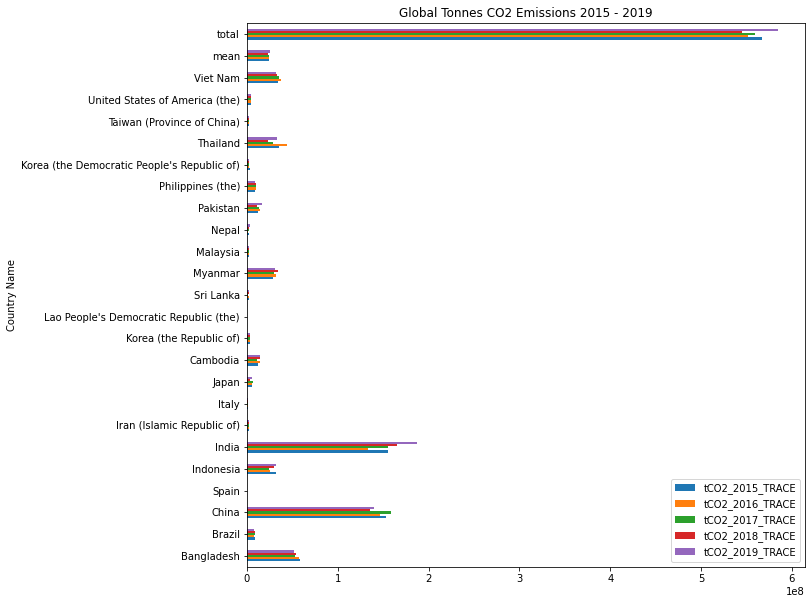

In [19]:
TRACE_CO2_df.plot(kind = "barh", x = 'country_name_TRACE', y = ['tCO2_2015_TRACE','tCO2_2016_TRACE','tCO2_2017_TRACE','tCO2_2018_TRACE','tCO2_2019_TRACE',], xlabel = "Country Name", ylabel = "Tonnes C02", title = "Global Tonnes CO2 Emissions 2015 - 2019", figsize = (10,10))

### CO2 Tonnage Map TRACE

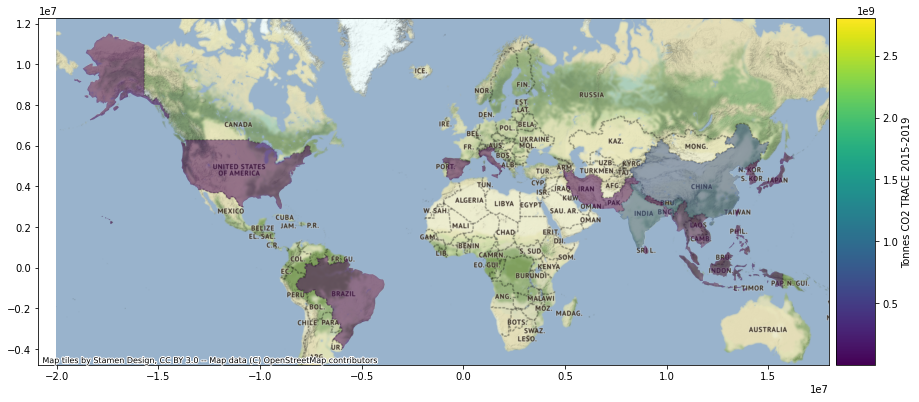

In [20]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merge_map = merge_geo_df.plot(column='Total_CO2_TRACE', ax=ax, legend=True, cax=cax, alpha = .5,legend_kwds={'label':  "Tonnes CO2 TRACE 2015-2019",
                        'orientation': "vertical"})
cx.add_basemap(merge_map, zoom=3)

## Conclusions

The TRACE data set on average reports about 2.8 percent more methane emissions than the FAOSTAT data set.  This equates to a total methane emmissions estimates difference of 3,100,772 tonnes over a 5 year period.  The CO2equivalent over that same period is 77,519,300 tonnes.  Neither value is negligible.  It is also important that Methane co2 equivalency is reported in 50 and 100 year greenhouse emissions goals.  